In [43]:
!pip install contractions

# 1. Import the libraries, load dataset, the print shape of data, data description. 


In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re, string, unicodedata
import nltk
nltk.download('stopwords')

import contractions

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet    # Stopwords, and wordnet corpus
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
import os
path = '/content/drive/MyDrive/data/'
#path = os.getcwd() + "/"
print (path)

/content/drive/MyDrive/data/


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:

orig_data = pd.read_csv(path+'Tweets.csv')

In [48]:
orig_data.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [49]:
print(orig_data.shape)

(14640, 15)


There are 14640 rows and 15 columns in the dataset

In [50]:
print(orig_data.describe())

           tweet_id  ...  retweet_count
count  1.464000e+04  ...   14640.000000
mean   5.692184e+17  ...       0.082650
std    7.791112e+14  ...       0.745778
min    5.675883e+17  ...       0.000000
25%    5.685592e+17  ...       0.000000
50%    5.694779e+17  ...       0.000000
75%    5.698905e+17  ...       0.000000
max    5.703106e+17  ...      44.000000

[8 rows x 4 columns]


In [51]:
print(orig_data.isna().sum())

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


There are many missing values in differen columns, but we are going to drop those columns, so we can ignore missing values

In [52]:
print(orig_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [53]:
print(orig_data['airline_sentiment'].value_counts())

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


2/3 of the tweets are negative

# 2. Understand of data columns: 

## Create a small data set to test data set transformations

Now we are going to create classes for data set pre-processing and combine them into a pipeleine

In [54]:
first5 = orig_data.head(5)
first5

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## a. Drop all other columns except “text” and “airline_sentiment”.

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin

In [56]:
def my_print(a):
    """
    Function my_print prints out parameter a if global 
    variable debug is True. Otherwise does nothing\
    """
    global debug
    try: debug
    except NameError: debug=False
    if debug:
        print(a)

## disable debugging info print out
debug=True

In [57]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """
    class ColumnDropper(columns) drops columns in the dataframe.
    columns - list of columns to be droppped
    """    
    def __init__(self, columns):
        self.columns = columns
        return
    def fit(self, X, y=None, **fit_params):
        my_print ("-- ColumnDropper::fit() --")
        # Do nothing
        return self
    def transform(self, X):
        my_print ("-- ColumnDropper::transform() --")    
        new_X = X.drop(columns=self.columns)
        return new_X

In [58]:
columns_to_drop = first5.columns
print (columns_to_drop)

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


In [59]:
columns_to_drop = columns_to_drop.delete(1)
columns_to_drop = columns_to_drop.delete(-5)
print(columns_to_drop)

Index(['tweet_id', 'airline_sentiment_confidence', 'negativereason',
       'negativereason_confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'tweet_coord',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')


In [60]:
dropper = ColumnDropper(columns_to_drop)

In [61]:
dropper.fit(first5)
first5 = dropper.transform(first5)

-- ColumnDropper::fit() --
-- ColumnDropper::transform() --


## b. Check the shape of the data.

In [62]:
print(first5.shape)

(5, 2)


## c. Print the first 5 rows of data.

In [63]:
first5

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


# 3. Text pre-processing: Data preparation. 
## a. Html tag removal.
## b. Tokenization.
## c. Remove the numbers.
## d. Removal of Special Characters and Punctuations.
## e. Removal of stopwords
## f. Conversion to lowercase.
## g. Lemmatize or stemming.
## h. Join the words in the list to convert back to text string in the data frame. (So that each row contains the data in text format.)
## i. Print the first 5 rows of data after pre-processing.


In [64]:
import spacy
nlp = spacy.load('en', parse=True, tag=True, entity=True)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    class TextPreprocessor(type, nlp) preprocesses the text in column 'text'.
    Preprocessing includes:
     a. Html tag removal.
     b. Tokenization.
     c. Removat of the numbers.
     d. Removal of Special Characters and Punctuations.
     e. Removal of stopwords
     f. Conversion to lowercase.
     g. Lemmatization or stemming.
    Parameters:
    type - tells TextPreprocessor whether lemmatize or stem the text
           Values: 'lemma' or 'stem'
    nlp  - language model for lemmatization
    """    
    def __init__(self, my_type, nlp):
        self.type_ = my_type
        self.nlp_ = nlp
        self.stemmer_ = nltk.porter.PorterStemmer()
        return
    
    def remove_html(self, text):
        soup = BeautifulSoup(text, "html.parser")
        text_no_html = soup.get_text()
        return text_no_html
    
    ## If particular airline receives mostly positive/negative reviews
    ## Airline name itself may become a positive/negative marker
    ## revove airline names from the tweets
    def remove_airline_reference(self, text):
        pattern = r'@[a-zA-Z0-9]+[\t\s]+' 
        new_text = re.sub(pattern, '', text)
        return new_text
    
    def remove_contractions(self, text):
        expanded_words = []    
        for word in text.split():
          # using contractions.fix to expand the shotened words
          expanded_words.append(contractions.fix(word)) 
        return " ".join(expanded_words)         
    
    def tokenize(self, text):
        tokens = word_tokenize(text)
        return tokens
        
    
    def remove_non_ascii(self, words):
        new_words = []
        for w in words:
            w = unicodedata.normalize('NFKD', w).encode('ascii', 'ignore').decode('utf-8','ignore')
            new_words.append(w)
        return new_words

    def to_lower(self, words):
        new_words = []
        for w in words:
            w = w.lower()
            new_words.append(w)
        return new_words


    def remove_punctuations(self, words):
        pattern = r'[^a-zA-Z0-9\s]' 
        new_words = []
        for w in words:
            w = re.sub(pattern, '', w)
            if len(w) > 0:
                new_words.append(w)        
        return new_words

    def remove_digits(self, words):
        pattern = r'[0-9]' 
        new_words = []
        for w in words:
            w = re.sub(pattern, '', w)
            if len(w) > 0:
                new_words.append(w)        
        return new_words

    def remove_stopwords(self, words):
        stopword_list = stopwords.words('english')
        stopword_list.remove('not')
        new_words = []
        for w in words:
            if w not in stopword_list:
                new_words.append(w)
        return new_words


    def convert_to_stem(self, words):
        new_words = []
        ps = nltk.porter.PorterStemmer()
        for w in words:
            w = ps.stem(w)
            new_words.append(w)        
        return new_words


    def lemmatize(self, words):
        global nlp
        new_words = []
        twit = " ".join(words)
        text = nlp(twit)
        for w in words:
            #text = nlp(w)
            w = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
            new_words.append(w)
        return new_words


    def preprocess_text(self, text):
        new_text  = self.remove_html(text)
        #new_text  = self.remove_airline_reference(new_text)
        new_text  = self.remove_contractions(new_text)      
        words     = self.tokenize(new_text)
        words     = self.remove_non_ascii(words)
        words     = self.to_lower(words)
        words     = self.remove_punctuations(words)
        words     = self.remove_digits(words)
        words     = self.remove_stopwords(words)
        if (self.type_ == 'stem'):
            words     = self.convert_to_stem(words)
        else:
            words     = self.lemmatize(words)
        ## if tweet consists of stopwords
        ## add something neutral
        if len(words) == 0:
            words.append("ok")
        new_text  = " ".join(words)
        return new_text

    def fit(self, X, y=None, **fit_params):
        my_print ("-- TextPreprocessor::fit() -- type: {}".format(self.type_))
        ## do nothing
        return self
    
    def transform(self, X):
        my_print ("-- TextPreprocessor::transform() --")    
        new_X = X.copy()
        #self.preprocess_text('abc')
        new_X['text'] = new_X['text'].apply(self.preprocess_text)
        return new_X

    def get_params(self, deep=True):
        return {"my_type": self.type_,
               "nlp": self.nlp_}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            p = parameter
            if parameter == "my_type":
                p = "type_"
                self.type_ = value
            elif parameter == "nlp":
                p = "nlp_"
                self.nlp_ = value
            my_print("TextPreprocessor setattr {} = {}".format(p, value))
            #setattr(self, p, value)
        return self

    

In [66]:
text_prepocessor = TextPreprocessor('stem',nlp)
text_prepocessor.fit(first5)
first5_stem = text_prepocessor.transform(first5)
first5_stem

-- TextPreprocessor::fit() -- type: stem
-- TextPreprocessor::transform() --


,airline_sentiment,text
0,neutral,virginamerica dhepburn said
1,positive,virginamerica plu ad commerci experi tacki
2,neutral,virginamerica not today must mean need take an...
3,negative,virginamerica realli aggress blast obnoxi ente...
4,negative,virginamerica realli big bad thing


In [67]:
text_prepocessor = TextPreprocessor('lemma',nlp)
text_prepocessor.fit(first5)
first5_lemma = text_prepocessor.transform(first5)
first5_lemma

-- TextPreprocessor::fit() -- type: lemma
-- TextPreprocessor::transform() --


,airline_sentiment,text
0,neutral,virginamerica dhepburn say virginamerica dhepb...
1,positive,virginamerica plus add commercial experience t...
2,neutral,virginamerica not today must mean nee take ano...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing virginameri...


# 4. Vectorization: 
## a. Use CountVectorizer.
## b. Use TfidfVectorizer.

In [68]:
class TextVectorzer(BaseEstimator, TransformerMixin):
    """
    class TextVectorzer(type) Vectorizes the text in column 'text'.
    Parameters:
    type - tells TextVectorzer whether to use Count or TF/IDF vectorization
           Values: 'count' or 'tfidf'
    max_features - maximun number of features
    ngram_range  - ngram range
    """    
    vectorizer_ = None
    def __init__(self, my_type, max_features, ngram_range):
        self.type_ = my_type
        self.max_features_ = max_features
        self.ngram_range_ = ngram_range
        return
    

    def fit(self, X, y=None, **fit_params):
        my_print ("-- TextVectorzer::fit() -- type: {}, max_features: {}, ngram_range: {}".format( 
                  self.type_, self.max_features_, self.ngram_range_))
        if (self.type_ == "count"):
            self.vectorizer_ = CountVectorizer(max_features=self.max_features_, ngram_range=self.ngram_range_)
        else:
            self.vectorizer_ = TfidfVectorizer(max_features=self.max_features_, ngram_range=self.ngram_range_)
        self.vectorizer_.fit(X.text)
        return self
    
    def transform(self, X):
        my_print ("-- TextVectorzer::transform() --")
        features = self.vectorizer_.transform(X['text'])
        feature_df = pd.DataFrame(features.toarray(), columns=self.vectorizer_.get_feature_names())
        new_X = feature_df.copy()
        if 'airline_sentiment' in X.columns:
            new_X['airline_sentiment'] = X['airline_sentiment'].to_numpy()
        new_X['text'] = X['text'].to_numpy()        
        return new_X
    
    def get_params(self, deep=True):
        return {"my_type": self.type_,
               "max_features": self.max_features_,
               "ngram_range": self.ngram_range_}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            if parameter == "my_type":
                p = "type_"
                self.type_ = value
            elif parameter == "max_features":
                p = "max_features_"
                self.max_features_ = value
            elif parameter == "ngram_range":
                p = "ngram_range_"
                self.ngram_range_ = value
            my_print("TextVectorzer setattr {} = {}".format(p, value))    
            #setattr(self, parameter, value)
        return self
    

In [69]:
vectorizer = TextVectorzer('count', 10, (1,1))
vectorizer.fit(first5_lemma)
first5_count = vectorizer.transform(first5_lemma)
print(first5_count)

-- TextVectorzer::fit() -- type: count, max_features: 10, ngram_range: (1, 1)
-- TextVectorzer::transform() --
   aggressive  ...                                               text
0           0  ...  virginamerica dhepburn say virginamerica dhepb...
1           0  ...  virginamerica plus add commercial experience t...
2           0  ...  virginamerica not today must mean nee take ano...
3          10  ...  virginamerica really aggressive blast obnoxiou...
4           0  ...  virginamerica really big bad thing virginameri...

[5 rows x 12 columns]


In [70]:
vectorizer = TextVectorzer('tfidf', 10, (1,1))
vectorizer.fit(first5_lemma)
first5_count = vectorizer.transform(first5_lemma)
print(first5_count)

-- TextVectorzer::fit() -- type: tfidf, max_features: 10, ngram_range: (1, 1)
-- TextVectorzer::transform() --
   aggressive  ...                                               text
0    0.000000  ...  virginamerica dhepburn say virginamerica dhepb...
1    0.000000  ...  virginamerica plus add commercial experience t...
2    0.000000  ...  virginamerica not today must mean nee take ano...
3    0.335616  ...  virginamerica really aggressive blast obnoxiou...
4    0.000000  ...  virginamerica really big bad thing virginameri...

[5 rows x 12 columns]


## Test classes in a pipeline

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [72]:
dropper = ColumnDropper(columns_to_drop)
text_prepocessor = TextPreprocessor(my_type='lemma', nlp='nlp')
vectorizer = TextVectorzer('tfidf', 8, (1,1))
dropper2 = ColumnDropper(['text'])
pipeline = make_pipeline(dropper, text_prepocessor, vectorizer, dropper2)
sample_data = orig_data.sample(5).drop(columns='airline_sentiment')
pipeline.fit(sample_data)
transformed_sample_data = pipeline.transform(sample_data)
print(transformed_sample_data)

-- ColumnDropper::fit() --
-- ColumnDropper::transform() --
-- TextPreprocessor::fit() -- type: lemma
-- TextPreprocessor::transform() --
-- TextVectorzer::fit() -- type: tfidf, max_features: 8, ngram_range: (1, 1)
-- TextVectorzer::transform() --
-- ColumnDropper::fit() --
-- ColumnDropper::transform() --
-- TextPreprocessor::transform() --
-- TextVectorzer::transform() --
-- ColumnDropper::transform() --
        bag    flight        go    happen   instead  miss      next   orlando
0  0.707107  0.707107  0.000000  0.000000  0.000000   0.0  0.000000  0.000000
1  0.500000  0.500000  0.500000  0.000000  0.000000   0.5  0.000000  0.000000
2  0.000000  0.000000  0.374105  0.463693  0.463693   0.0  0.463693  0.463693
3  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000
4  0.000000  0.000000  0.000000  0.000000  0.000000   1.0  0.000000  0.000000


## Count words and find an optimal number of features

In [73]:
dropper_x1 = ColumnDropper(columns_to_drop)
dropper_x2 = ColumnDropper('airline_sentiment')
dropper_x1.fit(orig_data)
transformed_data = dropper_x1.transform(orig_data)
dropper_x2.fit(orig_data)
transformed_data = dropper_x2.transform(transformed_data)

-- ColumnDropper::fit() --
-- ColumnDropper::transform() --
-- ColumnDropper::fit() --
-- ColumnDropper::transform() --


In [74]:
preprocessor_x1 = TextPreprocessor('stem', nlp)
preprocessor_x1.fit(transformed_data)
transformed_data = preprocessor_x1.transform(transformed_data)

-- TextPreprocessor::fit() -- type: stem
-- TextPreprocessor::transform() --


In [75]:
vectorizer_x1 = TextVectorzer('count', None, (1,1))
vectorizer_x1.fit(transformed_data)
transformed_data = vectorizer_x1.transform(transformed_data)

-- TextVectorzer::fit() -- type: count, max_features: None, ngram_range: (1, 1)
-- TextVectorzer::transform() --


In [76]:
transformed_data.head(10)

,aa,aaaand,aaadvantag,aaalwaysl,aaba,aacom,aacustomerservic,aadavantag,aadelay,aadfw,aadv,aadvantag,aafail,aal,aano,aaron,aarp,aaso,aateam,aau,ab,aback,abandon,abassinet,abbrev,abc,abcdef,abcletjetbluestreamfe,abcnetwork,abcnew,abcnewsbayarea,abcwtvd,abduct,abi,abidfw,abigailedg,abil,abl,aboard,aboout,...,yr,yrold,yroldtwin,ystday,ystrdi,yuck,yucki,yulord,yuma,yummi,yup,yvonn,yvonneokaka,yvr,yxe,yxu,yyc,yyj,yyz,yyzua,zabsonr,zackscom,zakkohan,zambia,zccu,zero,zfv,zigzag,zip,zipper,zj,zkatcher,zombi,zone,zoom,zrh,zrhairport,zuke,zurich,zurichnew
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
transformed_data.shape

(14640, 11111)

There are 11111 words in 14640 documents

In [78]:
df = transformed_data.sum()

In [79]:
l = df.to_list()
f = []
for e in l:
  if isinstance(e, np.int64):
    f.append(e)

f= sorted(f, reverse=True)

In [80]:
from pandas.core.frame import DataFrame
df = DataFrame({"F": np.array(f)})

In [81]:
df = df.sort_values("F", ascending=False)

[Text(0, 0, '0.5 %'),
 Text(0, 0, '0.6 %'),
 Text(0, 0, '0.7 %'),
 Text(0, 0, '0.75 %'),
 Text(0, 0, '0.8 %'),
 Text(0, 0, '0.85 %'),
 Text(0, 0, '0.9 %'),
 Text(0, 0, '0.95 %'),
 Text(0, 0, '0.99 %')]

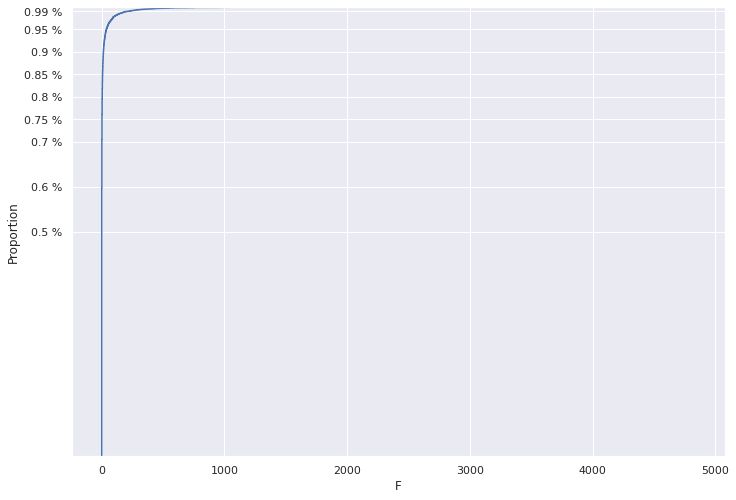

In [82]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

y_ticks = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
y_ticklabels = [f'{t} %' for t in y_ticks]

ax = sns.ecdfplot(x=df.F)

ax.yaxis.set_ticks(y_ticks)
ax.yaxis.set_ticklabels(y_ticklabels)

more then 99% of text consist of 500 most popular words

# 5. Fit and evaluate the model using both types of vectorization. 


## Split data into training and test sets

In [83]:
X = orig_data.drop(columns='airline_sentiment')
y = orig_data['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2, stratify=y)

In [84]:
from sklearn import metrics as metrics

In [85]:
def get_metrics_score(model, X_train, y_train, pred_train, X_test, y_test, pred_test, flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    average = 'macro'
    
    #Predicting on train and tests
    #pred_train = model.predict(X_train)
    #pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = metrics.accuracy_score(y_train, pred_train)
    test_acc  = metrics.accuracy_score(y_test,  pred_test)
    
    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train,average=average)
    test_recall = metrics.recall_score(y_test,pred_test,average=average)
    
    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train,average=average)
    test_precision = metrics.precision_score(y_test,pred_test,average=average)
    
    train_f1 = metrics.f1_score(y_train,pred_train,average=average)
    test_f1 = metrics.f1_score(y_test,pred_test,average=average)
    
    train_cm = metrics.confusion_matrix(y_train, pred_train)
    test_cm  = metrics.confusion_matrix(y_test, pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,\
                       test_precision, train_f1, test_f1, train_cm, test_cm))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",train_acc)
        print("Accuracy on test set : ",test_acc)
        print("Recall on training set : ",train_recall)
        print("Recall on test set : ",test_recall)
        print("Precision on training set : ",train_precision)
        print("Precision on test set : ",test_precision)
        print("F1 on training set : ",train_f1)
        print("F1 on test set : ",test_f1)
        print("Confusion matrix on train set:\n", train_cm)
        print("Confusion matrix on test set:\n", test_cm)
        print("Classification report on Test set:\n", metrics.classification_report(y_test, pred_test, \
                target_names=['negative', 'neutral', 'positive']))
    
    return score_list # returning the list with train and test scores

In [86]:
def make_confusion_matrix(cm,labels=['negative', 'neutral', 'positive']):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - Negative","Actual - Neutral", "Actual - Positive"]],
                  columns = [i for i in ["Predicted - Negative","Predicted - Neutral", "Predicted - Positive"]])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

## Build random forest model

In [87]:
from sklearn.ensemble import RandomForestClassifier


In [88]:
import time

In [89]:
debug = False

Creayin a base model. Wil use stemming for text preprocessing and bag of words as a vectorizer. Limit number of features by 500 and will use single words and bigrams as features

In [90]:
dropper = ColumnDropper(columns_to_drop)
text_prepocessor = TextPreprocessor('stem', nlp)
vectorizer = TextVectorzer('count', 500, (1,2))
dropper2 = ColumnDropper(['text'])
forest = RandomForestClassifier(n_estimators = 200,n_jobs=16, class_weight='balanced', random_state=1) 
model = make_pipeline(dropper, text_prepocessor, vectorizer, dropper2, forest)

In [91]:
start = time.time()

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

rf_score = get_metrics_score(model, X_train, y_train, pred_train, X_test,y_test, pred_test)
finish = time.time()
print ("Elapsed time {} seconds".format(int(finish-start)))

Accuracy on training set :  0.9834357923497268
Accuracy on test set :  0.7585382513661202
Recall on training set :  0.9806153166328119
Recall on test set :  0.6685410911828433
Precision on training set :  0.9732227806219234
Precision on test set :  0.6884142779216694
F1 on training set :  0.9767297077123365
F1 on test set :  0.6771187590739721
Confusion matrix on train set:
 [[7240   95    7]
 [   1 2444   34]
 [   1   56 1834]]
Confusion matrix on test set:
 [[1617  145   74]
 [ 233  306   81]
 [  93   81  298]]
Classification report on Test set:
               precision    recall  f1-score   support

    negative       0.83      0.88      0.86      1836
     neutral       0.58      0.49      0.53       620
    positive       0.66      0.63      0.64       472

    accuracy                           0.76      2928
   macro avg       0.69      0.67      0.68      2928
weighted avg       0.75      0.76      0.75      2928

Elapsed time 33 seconds


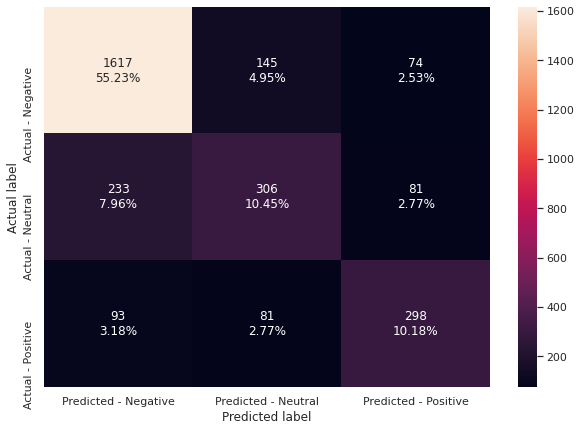

In [92]:
make_confusion_matrix(rf_score[-1])

Negative reviews are detected pretty well, but there are many mistakes in neutral and positive reviews.
Next let's try to use lemmatizatiaon for text pre-processing and TFIDF for vectoriztaion

In [93]:
dropper = ColumnDropper(columns_to_drop)
text_prepocessor = TextPreprocessor('lemma', nlp)
vectorizer = TextVectorzer('tfidf', 500, (1,2))
dropper2 = ColumnDropper(['text'])
forest = RandomForestClassifier(n_estimators = 200,n_jobs=16, class_weight='balanced', random_state=1) 
model2 = make_pipeline(dropper, text_prepocessor, vectorizer, dropper2, forest)

In [94]:
start = time.time()

model2.fit(X_train, y_train)

pred_train2 = model2.predict(X_train)
pred_test2 = model2.predict(X_test)

rf_score2 = get_metrics_score(model2, X_train, y_train, pred_train2, X_test,y_test, pred_test2)

finish = time.time()
print ("Elapsed time {} seconds".format(int(finish-start)))


Accuracy on training set :  0.9808743169398907
Accuracy on test set :  0.7646857923497268
Recall on training set :  0.9775447919846579
Recall on test set :  0.6605469334727796
Precision on training set :  0.9682293252879298
Precision on test set :  0.7044666553032818
F1 on training set :  0.972784359089073
F1 on test set :  0.678329683065957
Confusion matrix on train set:
 [[7232   91   19]
 [   6 2416   57]
 [   3   48 1840]]
Confusion matrix on test set:
 [[1660  122   54]
 [ 255  295   70]
 [ 112   76  284]]
Classification report on Test set:
               precision    recall  f1-score   support

    negative       0.82      0.90      0.86      1836
     neutral       0.60      0.48      0.53       620
    positive       0.70      0.60      0.65       472

    accuracy                           0.76      2928
   macro avg       0.70      0.66      0.68      2928
weighted avg       0.75      0.76      0.76      2928

Elapsed time 219 seconds


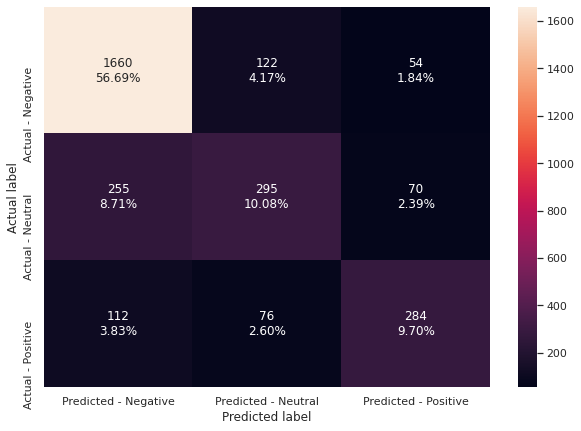

In [95]:
make_confusion_matrix(rf_score2[-1])

Results are pretty similar to the base model

## Random search on Random forest models

In [96]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

In [97]:
n_iter = 100
n_jobs = 1

Let's try hyperparameter tuning to improve recall on neutral and positive tweets.
Besides random forest parameters we will tune text preprocessing and vectorization parameters:
- using stemming or lemmatizations
- using bag of words or TFIDF
- number of features
- ngram range

In [98]:
#my_type, max_features, ngram_range
rf_param_grid = {\
                 'textpreprocessor__my_type' : ['stem','lemma'], 
                 'textpreprocessor__nlp' : [nlp],
                 'textvectorzer__my_type' : ['count', 'tfidf'],
                 'textvectorzer__max_features' : stats.randint(200,2000),
                 'textvectorzer__ngram_range' : [(1,2), (1,3), (2,3), (2,2)],                   
                 'randomforestclassifier__class_weight':['balanced', None],
                 'randomforestclassifier__n_estimators': stats.randint(50,200),
                 'randomforestclassifier__max_features' : stats.uniform(0.6,0.4),
                 'randomforestclassifier__max_samples' : stats.uniform(0.6,0.4),
                 'randomforestclassifier__max_depth' : stats.randint(5,15),
                 'randomforestclassifier__n_jobs' : [16],               
                }


In [99]:
from sklearn.metrics import make_scorer

scorer = make_scorer(metrics.recall_score, average='macro')

#grid = RandomizedSearchCV(model , param_distributions=rf_param_grid, cv = 4, n_jobs=n_jobs, n_iter=n_iter,\
#                    scoring=scorer, random_state=1)

start = time.time()
#result= grid.fit( X_train, y_train) 

#rf_rand_model = grid.best_estimator_

Randomized search take about 7-10 hours to complete. So we commented out the search process and reuse pre-calculated result in the cell below:

In [100]:
#Results of random search:

rf = RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.6268128200343545,
                       max_samples=0.9247086058339146, n_estimators=66,
                       n_jobs=16, random_state=1) 
tv = TextVectorzer(max_features=1893, my_type='tfidf', ngram_range=(1, 3)) 
tp = TextPreprocessor(my_type='lemma',
                 nlp=nlp)
rf_rand_model = make_pipeline(dropper, tp, tv, dropper2, rf)

rf_rand_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columndropper-1',
                 ColumnDropper(columns=Index(['tweet_id', 'airline_sentiment_confidence', 'negativereason',
       'negativereason_confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'tweet_coord',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object'))),
                ('textpreprocessor',
                 TextP...
                                        class_weight='balanced',
                                        criterion='gini', max_depth=14,
                                        max_features=0.6268128200343545,
                                        max_leaf_nodes=None,
                                        max_samples=0.9247086058339146,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samp

In [101]:

pred_train_rand_rf = rf_rand_model.predict(X_train)
pred_test_rand_rf = rf_rand_model.predict(X_test)

rf_rand_score = get_metrics_score(rf_rand_model, X_train, y_train, pred_train_rand_rf, X_test,y_test, pred_test_rand_rf)

finish = time.time()
print ("Elapsed time {} seconds".format(int(finish-start)))

Accuracy on training set :  0.6906591530054644
Accuracy on test set :  0.6577868852459017
Recall on training set :  0.7016210549166959
Recall on test set :  0.6535906617066364
Precision on training set :  0.6920411353335224
Precision on test set :  0.6411932159723984
F1 on training set :  0.6699919945190557
F1 on test set :  0.6267237701792162
Confusion matrix on train set:
 [[4905 2173  264]
 [ 361 1969  149]
 [ 120  556 1215]]
Confusion matrix on test set:
 [[1206  542   88]
 [ 124  438   58]
 [  51  139  282]]
Classification report on Test set:
               precision    recall  f1-score   support

    negative       0.87      0.66      0.75      1836
     neutral       0.39      0.71      0.50       620
    positive       0.66      0.60      0.63       472

    accuracy                           0.66      2928
   macro avg       0.64      0.65      0.63      2928
weighted avg       0.74      0.66      0.68      2928

Elapsed time 237 seconds


In [102]:
print(rf_rand_model[-1], "\n", rf_rand_model[-3], "\n", rf_rand_model[-4])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=14,
                       max_features=0.6268128200343545, max_leaf_nodes=None,
                       max_samples=0.9247086058339146,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=66, n_jobs=16,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False) 
 TextVectorzer(max_features=1893, my_type='tfidf', ngram_range=(1, 3)) 
 TextPreprocessor(my_type='lemma',
                 nlp=<spacy.lang.en.English object at 0x7f4751990650>)


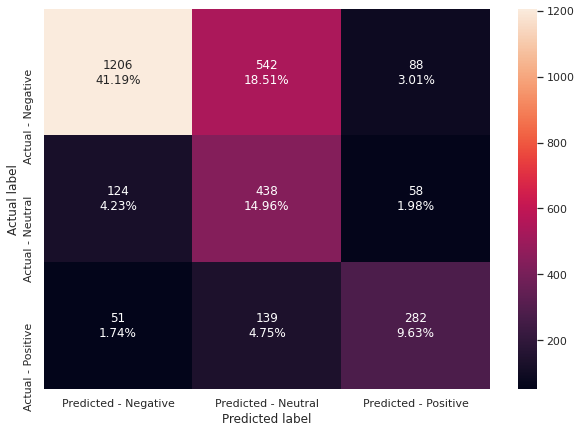

In [103]:
make_confusion_matrix(rf_rand_score[-1])

Recall improved for neutral tweets, degraded for negative tweets and didn't change for positive tweets
We assume that negative tweets are most important for the airlines, so we will keep base model as a production model

## RNN

Let's try to build reinforcement neural network model

In [104]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, BatchNormalization
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

Preprocess the text

In [105]:
class TextPreprocessorRnn(BaseEstimator, TransformerMixin):
    """
    class TextPreprocessorRnn(nlp) preprocesses the text in column 'text'
    for RNN
    Preprocessing includes:
     a. Html tag removal.
     b. Tokenization.
     c. Removat of the numbers.
     d. Removal of Special Characters and Punctuations.
     e. Conversion to lowercase.
    Parameters:
    None
    """    
    def __init__(self):
        return
    
    def remove_html(self, text):
        soup = BeautifulSoup(text, "html.parser")
        text_no_html = soup.get_text()
        return text_no_html
    
    def remove_contractions(self, text):
        expanded_words = []    
        for word in text.split():
          # using contractions.fix to expand the shotened words
          expanded_words.append(contractions.fix(word)) 
        return " ".join(expanded_words)         
    
    def tokenize(self, text):
        tokens = word_tokenize(text)
        return tokens
        
    
    def remove_non_ascii(self, words):
        new_words = []
        for w in words:
            w = unicodedata.normalize('NFKD', w).encode('ascii', 'ignore').decode('utf-8','ignore')
            new_words.append(w)
        return new_words

    def to_lower(self, words):
        new_words = []
        for w in words:
            w = w.lower()
            new_words.append(w)
        return new_words


    def remove_punctuations(self, words):
        pattern = r'[^a-zA-Z0-9\s]' 
        new_words = []
        for w in words:
            w = re.sub(pattern, '', w)
            if len(w) > 0:
                new_words.append(w)        
        return new_words

    def remove_digits(self, words):
        pattern = r'[0-9]' 
        new_words = []
        for w in words:
            w = re.sub(pattern, '', w)
            if len(w) > 0:
                new_words.append(w)        
        return new_words

    def preprocess_text(self, text):
        new_text  = self.remove_html(text)
        #new_text  = self.remove_airline_reference(new_text)
        new_text  = self.remove_contractions(new_text)      
        words     = self.tokenize(new_text)
        words     = self.remove_non_ascii(words)
        words     = self.to_lower(words)
        words     = self.remove_punctuations(words)
        words     = self.remove_digits(words)
        ## if tweet consists of stopwords
        ## add something neutral
        if len(words) == 0:
            words.append("ok")
        new_text  = " ".join(words)
        return new_text

    def fit(self, X, y=None, **fit_params):
        my_print ("-- TextPreprocessorRnn::fit() -- ")
        ## do nothing
        return self
    
    def transform(self, X):
        my_print ("-- TextPreprocessorRnn::transform() --")    
        new_X = X.copy()
        new_X['text'] = new_X['text'].apply(self.preprocess_text)
        return new_X

    

In [106]:
text_prepocessor_rnn = TextPreprocessorRnn()
text_prepocessor_rnn.fit(first5)
first5_rnn = text_prepocessor_rnn.transform(first5)
first5_rnn

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus you have added commercials ...
2,neutral,virginamerica i did not today must mean i need...
3,negative,virginamerica it is really aggressive to blast...
4,negative,virginamerica and it is a really big bad thing...


Text vectorization

In [107]:
class TextVectorzerRnn(BaseEstimator, TransformerMixin):
    """
    class TextVectorzerRnn(type) Vectorizes the text in column 'text'.
    Parameters:
      max_features - maximun number of features
    """    
    tokenizer_ = None
    def __init__(self, max_features):
        self.max_features_ = max_features       
        return
    

    def fit(self, X, y=None, **fit_params):
        my_print ("-- TextVectorzer::fit() -- max_features: {}".format(
             self.max_features_))
        self.tokenizer_ = Tokenizer(num_words=self.max_features_, split=' ')
        self.tokenizer_.fit_on_texts(X['text'].values)
        return self
    
    def transform(self, X):
        my_print ("-- TextVectorzer::transform() --")
        new_X = self.tokenizer_.texts_to_sequences(X['text'].values)
        new_X = pad_sequences(new_X, maxlen=30) 
        return new_X


In [108]:
text_vectorizer_rnn = TextVectorzerRnn(max_features=5)
text_vectorizer_rnn.fit(first5_rnn)
first5_rnn_vectorized = text_vectorizer_rnn.transform(first5_rnn)
first5_rnn_vectorized

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 4, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 3, 2, 4],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 3, 3]], dtype=int32)

Test text preprocessing and vectorization in a pipeline

In [109]:
dropper = ColumnDropper(columns_to_drop)
text_prepocessor_rnn = TextPreprocessorRnn()
text_vectorizer_rnn = TextVectorzerRnn(max_features = 8)
pipeline = make_pipeline(dropper, text_prepocessor_rnn, text_vectorizer_rnn)
sample_data = orig_data.sample(5).drop(columns='airline_sentiment')
pipeline.fit(sample_data)
transformed_sample_data = pipeline.transform(sample_data)
print(transformed_sample_data)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 6 3 7 4 1 3 7 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 3 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 4 1]]


Encode y_train and y_test

In [110]:
y_train_encoded = pd.get_dummies(y_train, sparse=False)


In [111]:
y_test_encoded = pd.get_dummies(y_test, sparse=False)


In [112]:
print(y_train_encoded)

       negative  neutral  positive
1741          1        0         0
4117          0        1         0
14358         1        0         0
537           1        0         0
4154          0        1         0
...         ...      ...       ...
6232          0        1         0
8414          0        1         0
12156         0        0         1
5383          1        0         0
7679          1        0         0

[11712 rows x 3 columns]


In [113]:
print(y_test_encoded)

       negative  neutral  positive
1258          1        0         0
10945         1        0         0
1411          0        0         1
3768          1        0         0
5996          0        0         1
...         ...      ...       ...
3238          1        0         0
6721          0        1         0
13561         1        0         0
6749          1        0         0
9641          1        0         0

[2928 rows x 3 columns]


Build Sequential model

In [114]:
from keras.layers.core import Dropout

def build_model(max_fatures, embed_dim, lstm_out):
  model = Sequential()
  model.add(Embedding(max_fatures, embed_dim,input_length = 30))
  model.add(SpatialDropout1D(0.4))
  model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.15))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.35))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.45))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(3,activation='softmax'))
  #default lr=0.001
  model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.0002),
                metrics = ['accuracy'])
  return model


In [115]:
embed_dim = 128
lstm_out = 128
max_features = 1000

rnn = build_model(max_fatures=max_features, lstm_out=lstm_out, embed_dim=embed_dim)
        
print(rnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 128)           128000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1

In [116]:
dropper = ColumnDropper(columns_to_drop)
text_prepocessor_rnn = TextPreprocessorRnn()
text_vectorizer_rnn = TextVectorzerRnn(max_features = max_features)
pipeline = make_pipeline(dropper, text_prepocessor_rnn, text_vectorizer_rnn)
pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)


In [117]:
print(X_train_transformed.shape, y_train_encoded.shape)

(11712, 30) (11712, 3)


In [118]:
X_test_transformed = pipeline.transform(X_test)
print(X_test_transformed.shape, y_test_encoded.shape)


(2928, 30) (2928, 3)


In [119]:
print(X_test_transformed)

[[  0   0   0 ...  38   3   9]
 [  0  14   7 ... 159  56 132]
 [  0   0   0 ... 198  97 784]
 ...
 [  0   0   0 ... 110  37 186]
 [  0   0   0 ... 718  46  56]
 [  0   0   0 ...  24   4  49]]


In [120]:
history = rnn.fit(x= X_train_transformed, y=y_train_encoded, validation_split=0.2, epochs=25, batch_size=256)

Epoch 1/25
37/37 [==============================] - 33s 186ms/step - loss: 0.9749 - accuracy: 0.5997 - val_loss: 1.0521 - val_accuracy: 0.6270
Epoch 2/25
37/37 [==============================] - 6s 156ms/step - loss: 0.8359 - accuracy: 0.6333 - val_loss: 1.0396 - val_accuracy: 0.6270
Epoch 3/25
37/37 [==============================] - 6s 156ms/step - loss: 0.7833 - accuracy: 0.6482 - val_loss: 0.9972 - val_accuracy: 0.6351
Epoch 4/25
37/37 [==============================] - 6s 158ms/step - loss: 0.7390 - accuracy: 0.6633 - val_loss: 0.9609 - val_accuracy: 0.6837
Epoch 5/25
37/37 [==============================] - 6s 154ms/step - loss: 0.7054 - accuracy: 0.6848 - val_loss: 0.9161 - val_accuracy: 0.7025
Epoch 6/25
37/37 [==============================] - 6s 165ms/step - loss: 0.6789 - accuracy: 0.6977 - val_loss: 0.8826 - val_accuracy: 0.7008
Epoch 7/25
37/37 [==============================] - 6s 164ms/step - loss: 0.6502 - accuracy: 0.7102 - val_loss: 0.8617 - val_accuracy: 0.7234
Epoch

In [121]:
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

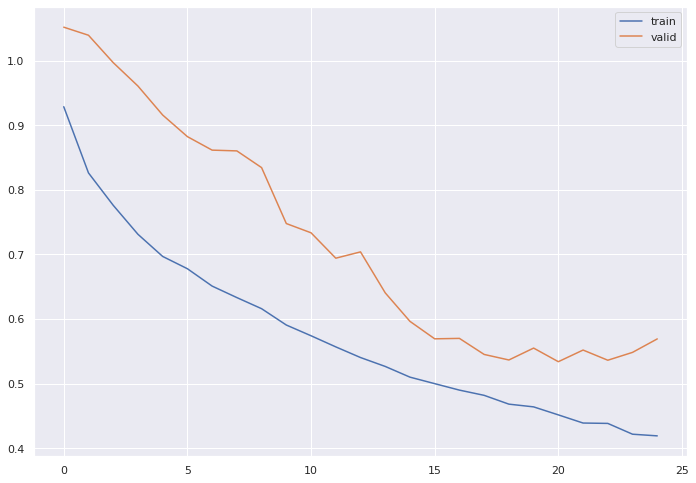

In [122]:
import matplotlib.pyplot as plt

plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


In [123]:

pred_test_rnn = rnn.predict(X_test_transformed)
pred_test_rnn = np.argmax(pred_test_rnn, axis=1)

pred_test_rnn = np.where(pred_test_rnn == 0, 'negative', pred_test_rnn)
pred_test_rnn = np.where(pred_test_rnn == '1', 'neutral', pred_test_rnn)
pred_test_rnn = np.where(pred_test_rnn == '2', 'positive', pred_test_rnn)

In [124]:
pred_train_rnn = rnn.predict(X_train_transformed)
pred_train_rnn = np.argmax(pred_train_rnn, axis=1)

pred_train_rnn = np.where(pred_train_rnn == 0, 'negative', pred_train_rnn)
pred_train_rnn = np.where(pred_train_rnn == '1', 'neutral', pred_train_rnn)
pred_train_rnn = np.where(pred_train_rnn == '2', 'positive', pred_train_rnn)

In [125]:
rnn_score = get_metrics_score(rnn, X_train, y_train, pred_train_rnn, X_test,y_test, pred_test_rnn)

Accuracy on training set :  0.8351263661202186
Accuracy on test set :  0.7636612021857924
Recall on training set :  0.8186186853819793
Recall on test set :  0.7350389194820953
Precision on training set :  0.7908475201860498
Precision on test set :  0.7106726371399543
F1 on training set :  0.7989912084496534
F1 on test set :  0.7163452484797052
Confusion matrix on train set:
 [[6259  892  191]
 [ 228 2066  185]
 [ 104  331 1456]]
Confusion matrix on test set:
 [[1460  286   90]
 [ 105  463   52]
 [  56  103  313]]
Classification report on Test set:
               precision    recall  f1-score   support

    negative       0.90      0.80      0.84      1836
     neutral       0.54      0.75      0.63       620
    positive       0.69      0.66      0.68       472

    accuracy                           0.76      2928
   macro avg       0.71      0.74      0.72      2928
weighted avg       0.79      0.76      0.77      2928



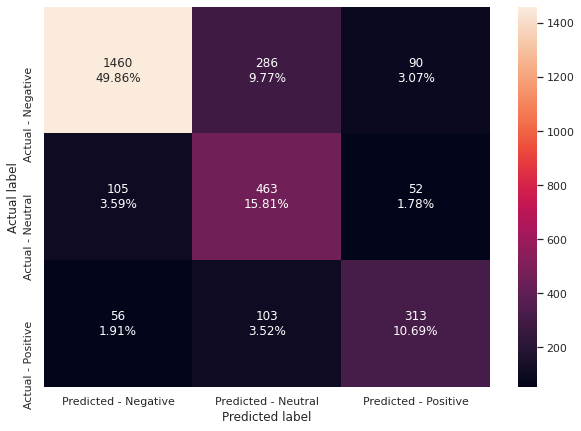

In [126]:
make_confusion_matrix(rnn_score[-1])

Using RNN we achieved better precision and recall on test data compared to base model

## Base model result pros-processing and analysis


Let's try to take a closer look at the base model results and try to figure out why it might misclassify some tweets

In [127]:
result_df = X_test.copy()

In [128]:
result_df['Y'] = y_test
result_df['predicted_rf'] = pred_test
result_df['correct'] = (result_df['Y'] == result_df['predicted_rf'])

In [129]:
result_df.isna().sum()

tweet_id                           0
airline_sentiment_confidence       0
negativereason                  1092
negativereason_confidence        810
airline                            0
airline_sentiment_gold          2924
name                               0
negativereason_gold             2925
retweet_count                      0
text                               0
tweet_coord                     2728
tweet_created                      0
tweet_location                   932
user_timezone                    938
Y                                  0
predicted_rf                       0
correct                            0
dtype: int64

First check how model accuracy depends on sentiment confidence

All tweets

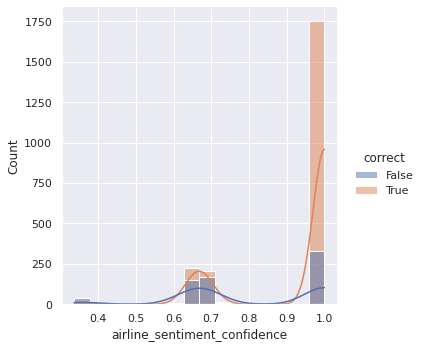

In [130]:
sns.displot(data=result_df, x = 'airline_sentiment_confidence', hue='correct', kde=True)

Neutral tweets

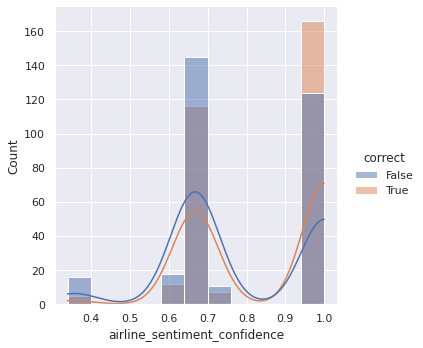

In [131]:
sns.displot(data=result_df[result_df['Y']=='neutral'], x = 'airline_sentiment_confidence', hue='correct', kde=True)

Positive and negative tweets

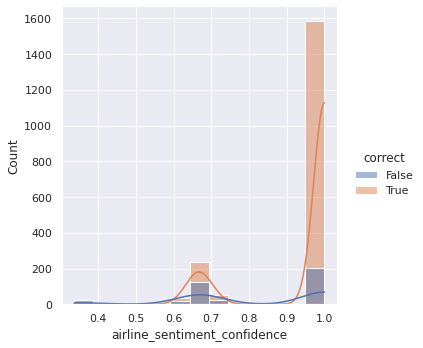

In [132]:
sns.displot(data=result_df[result_df['Y']!='neutral'], x = 'airline_sentiment_confidence', hue='correct', kde=True)

The higher *airline_sentiment_confidence*, the better we can identify sentiment. Which means our model correctly identifies strongly positive, negative and neutral tweets, but having trouble identifying tweets with weak sentiment. This trend is stronger for non-neutral tweets.

Now let's check if model behaviour depends on the reason of negative tweet

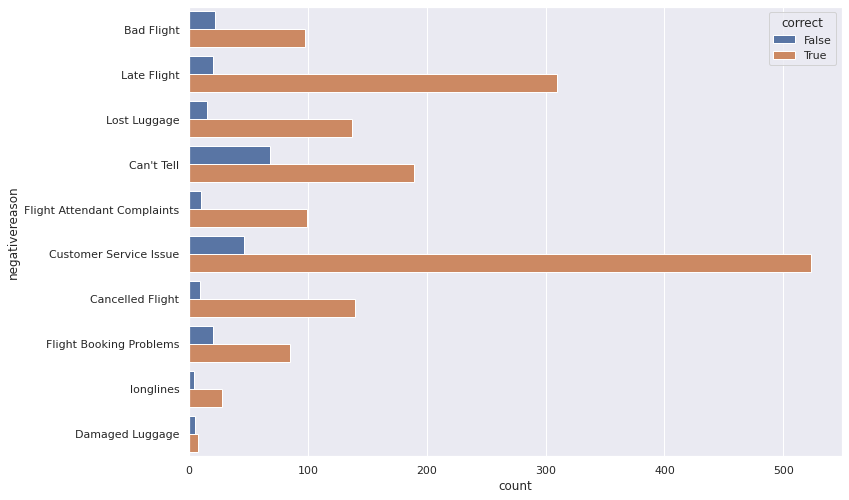

In [133]:
sns.countplot(data=result_df, y = 'negativereason', hue='correct')

The model correcly classifies negative tweets about late and cancelled flights and customer service issues. However, it has trouble with classification of tweets related to bad flight experience, booking issues and in case if the reason for negative tweet is unclear. 

Now let's take a look at a few random negaive tweets misclassified as positive

In [134]:
sample_df = result_df[(result_df['Y']=='negative')][result_df['predicted_rf']=='positive'][['text']].head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [135]:
pd.set_option('display.max_colwidth', 1000)
print(sample_df)
pd.set_option('display.max_colwidth', 100)

                                                                                                                                                text
7692      @JetBlue  thanks for response! Crew has been VERY patient with us, but they are also frustrated. Wouldn't be so bad but airport is closed!
2122    @united I hope your corporate office is ready to deal with the rage created by your shitty service and bullshit pilots. #UnitedAirlinesSucks
5020      @SouthwestAir Thanks for the terrible service! Stranded in MDW for 2 days, &amp; now can't find confirmation for rebooked flight from MKE.
5629                                 @SouthwestAir again another ride SW employee that printed out boarding passes. Deficiency in training obviously
13307  @AmericanAir thanks for the DM rescheduling. Unfortunately your operations process at LAX is chaos &amp; the reps refused to print the ticket
807                                                 @United I have no way of making phones calls... Need t

We can see a few sarcastic tweets that our model misclassified as positive. For example:

*@SouthwestAir Thanks for the terrible service! Stranded in MDW for 2 days, &amp; now can't find confirmation for rebooked flight from MKE.*

*@united Your "Loyalty Team" basically flipped me off via phone, but thanks. Maybe Google "loyalty" and get back to me? ^LOL*

Our model was probably confuced by words "Thank you", "Loyalty" and "Great job" in the tweets

Other misclassified tweets contain polite phrases which mean nothing in cotext of the problem description, but could confuce the model:

*@JetBlue  thanks for response! Crew has been VERY patient with us, but they are also frustrated. Wouldn't be so bad but airport is closed!*

*@United I have no way of making phones calls... Need to handle via Twitter/email/web. Thank you!*


# 6. Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset. 

## Summary:

- We used 14640 tweets about user's experience with airlines. The goal was to build a model for text classification, i.e. to classify tweeets as positive, negative or neutral.
- We pre-processed the data. Data pre-procesiisng includes:
1. Html tag removal.
1. Removal of the numbers.
2. Removal of Special Characters and Punctuations.
3. Removal of stopwords
4. Conversion to lowercase.
5. Lemmatization or stemming

- The pre-precessed data is converted to numbers using bag of words or TDIDF.
- We used Random forest model for classification.
- We used randomied search to try different pre processing techniques with different random forest hyperparameters.
- We also trained reinforcement neural network to build the model. This model turned to be better the random forst model
- Base model can classify positive and negative tweets better then neutral
- Base model can classify strongly positive and strongly negative tweets better then weakly positive/negative
- Model accuracy for negative tweets depends on the reason for the negative opinion.
- Model is having trouble classifying sarcastic negative tweets and negative tweets containing polite phrases like "Thank you" and "It would be nice to..." etc.
